In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numba
import numba.typed

from pathlib import Path
import glob
import tqdm
import sys
import seaborn as sns
import scipy.stats
import os
import pysam
import pprint
import pickle
import joblib
import subprocess
import io
import itertools
import warnings
import statsmodels.stats.proportion

import polars as pl
pl.Config.set_tbl_rows(-1)
pl.Config.set_fmt_str_lengths(50)


from brokenaxes import brokenaxes
from adjustText import adjust_text


# This is needed before pybedtools to make sure bedtools is imported on sanger JupyterHub 
os.environ["PATH"] += ":" + os.path.join(sys.prefix, "bin")
import pybedtools

pd.set_option('display.max_rows', 1000)


In [3]:
sys.path.append(str(Path(os.getcwd()).parent))
from src import liftover, annotate, diagnostics, inference
from src.IDs import *


# Add relevant fields to the dataframe of all reads

## Create reads dataframe

In [4]:
rahbari_df = pl.read_csv("/nfs/users/nfs_r/rs42/rs42/git/sperm/configs/Rahbari.tsv", separator='\t')

In [5]:
sudmant_df = pl.read_csv("/nfs/users/nfs_r/rs42/rs42/git/sperm/configs/Sudmant.tsv", separator='\t')

In [6]:
%%time
reads_filenames = ([
        (
            f"/lustre/scratch122/tol/projects/sperm/results/Rahbari_20250212/read_analysis/{sample_set}/{sample_id}/reads/{chrom}/all_reads_structure_annotated.parquet"
        ) 
        for sample_id, sample_set in tqdm.tqdm(rahbari_df.select("sample_id", "sample_set").unique().iter_rows())
        for chrom in aut_chrom_names
    ] + 
    [
        (
            f"/lustre/scratch122/tol/projects/sperm/results/Sudmant_20241121/read_analysis/{sample_set}/{sample_id}/reads/{chrom}/all_reads_structure_annotated.parquet"
        ) 
        for sample_id, sample_set in tqdm.tqdm(sudmant_df.select("sample_id", "sample_set").unique().iter_rows())
        for chrom in aut_chrom_names
    ]
)

9it [00:00, 14017.35it/s]
6it [00:00, 19909.67it/s]

CPU times: user 8 ms, sys: 52 ms, total: 60 ms
Wall time: 86.6 ms


## Subset of reads with at least 3 transitions

In [7]:
%%time
def F(filename):
    return (
        pl.scan_parquet(filename)
        .select(
            'read_name',
            'read_length',
            'chrom',
            'sample_id',
            'grch37_chromosome_size_in_bp',
            'high_quality_snp_positions',
            'CO_active_interval_start',
            'CO_active_interval_end',
            'CO_active_interval_length_bp',
            'grch37_reference_start',
            'grch38_reference_start',
            'grch37_reference_end',
            'grch38_reference_end',
            'grch37_reference_start_cM',
            'grch37_reference_end_cM',
            'CO_active_interval_start_cM',
            'CO_active_interval_end_cM',
            'CO_active_interval_crossover_prob',
            "mid_CO_active_interval_crossover_prob",
            'AA_motif_center_pos',
            'AA_heat',
            'AA_motif_strand',
            'CL4_motif_center_pos',
            'CL4_heat',
            'CL4_motif_strand',
            'is_high_quality_read',
            "min_coverage_hap1",
            "min_coverage_hap2",
            "high_quality_classification_class",
            "snp_positions_on_read", 
            "idx_transitions",
            "H3K4me3_signal_mean",
            "CTCF_signal_sum",
            "CTCF_signal_mean",
            "high_quality_classification_in_detectable_class",
            "full_read_crossover_prob",
            "total_mismatches",
            "is_contamination",
        )
        #.filter(pl.col("idx_transitions").list.len() >= 3)
        .filter(pl.col("high_quality_classification_class") == "CNCO")
        .filter(~pl.col("is_contamination"))
        .filter("is_high_quality_read")
        .filter(pl.col("CO_active_interval_crossover_prob") > 0)
        .collect(streaming=True)
    )
    
dense_reads_with_detection_df = pl.concat(
    joblib.Parallel(n_jobs=-1, verbose=1)(
        joblib.delayed(F)(filename) for filename in reads_filenames
    )
)

/nfs/users/nfs_r/rs42/rs42/miniforge3/envs/sperm/lib/python3.11/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: Using fork() can cause Polars to deadlock in the child process.
In addition, using fork() with Python in general is a recipe for mysterious
deadlocks and crashes.

The most likely reason you are seeing this error is because you are using the
multiprocessing module on Linux, which uses fork() by default. This will be
fixed in Python 3.14. Until then, you want to use the "spawn" context instead.

See https://docs.pola.rs/user-guide/misc/multiprocessing/ for details.

  pid = os.fork()
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    4.2s
/nfs/users/nfs_r/rs42/rs42/miniforge3/envs/sperm/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short

CPU times: user 913 ms, sys: 393 ms, total: 1.31 s
Wall time: 39.4 s


[Parallel(n_jobs=-1)]: Done 330 out of 330 | elapsed:   39.4s finished


# Basic stats

In [12]:
print("# of complex reads here:", len(dense_reads_with_detection_df))

# of complex reads here: 188


## Distribution of number of switches

In [13]:
n_switches_df = (dense_reads_with_detection_df
    .select(pl.col("idx_transitions").list.len().alias("n_switches"))
    .group_by("n_switches")
    .len()
    .sort("n_switches")
)

display(n_switches_df)

n_switches,len
u32,u32
3,103
4,55
5,11
6,13
7,3
8,2
9,1


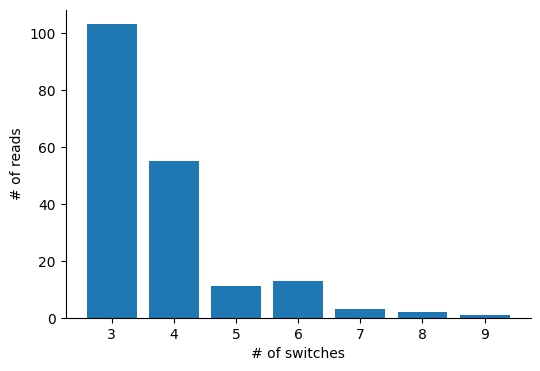

In [15]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.bar(
    x = n_switches_df["n_switches"],
    height = n_switches_df["len"],
);

sns.despine(ax=ax);
ax.set_xlabel("# of switches");
ax.set_ylabel("# of reads");

## BQ distribution?

In [17]:
output_path = Path("/lustre/scratch122/tol/projects/sperm/results/Rahbari_20250212")

complex_max_ann_snps_df = pl.concat([
    (
        pl.scan_parquet(glob.glob(str(
            output_path / f"read_analysis/{sample_set}/{sample_id}/{flow_cell}/*/annotated_0.95_high_confidence_snps.parquet"
        ))).with_columns(
            sample_id=pl.lit(sample_id), 
            flow_cell=pl.lit(flow_cell),
            flow_cell_type=pl.lit(flow_cell_type),        
        )
        .join(
            (dense_reads_with_detection_df
                .select("read_name", "sample_id", pl.col("idx_transitions").list.len().alias("n_switches"))
                .lazy()
            ),
            on=["read_name", "sample_id"],
        )
        .group_by("sample_id", "flow_cell", "flow_cell_type", "read_name")
        .agg(
            max_qual = pl.col("qual_start1").max(),
            min_qual = pl.col("qual_start1").min(),
            median_qual = pl.col("qual_start1").median(),            
            chrom = pl.col("ref1_name").first(),
            ref1_start = pl.col("ref1_start").first(),
            ref2_start = pl.col("ref2_start").first(),
            n_snps = pl.len(),
        )
        .collect(streaming=True)
    )
    for sample_set, sample_id, flow_cell, flow_cell_type, _ in tqdm.tqdm(rahbari_df.iter_rows())
#        if sample_id in ["PD50523b", "PD50477f"]
])


56it [09:43, 10.42s/it]


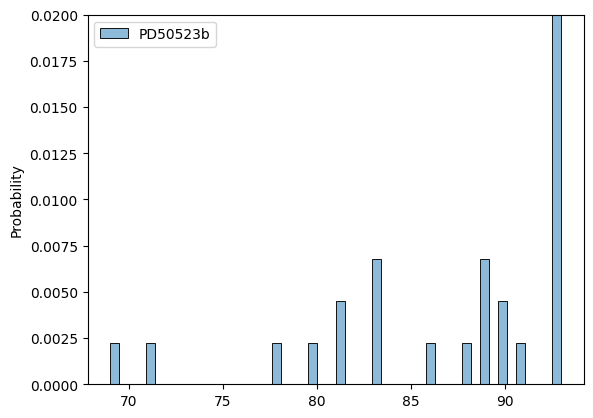

In [27]:
sns.histplot(
    [
        complex_max_ann_snps_df.filter((pl.col("n_snps") > 10) & (pl.col("sample_id") == "PD50523b"))["max_qual"], 
        complex_max_ann_snps_df.filter((pl.col("n_snps") > 10) & (pl.col("sample_id") != "PD50523b"))["max_qual"], 
    ],
    bins=50,
    stat="probability",
);

plt.legend(["PD50523b", "Others"]);
plt.ylim(0, 0.02);

In [10]:
output_path = Path("/lustre/scratch122/tol/projects/sperm/results/Rahbari_20250212")

complex_ann_snps_df = pl.concat([
    (
        pl.scan_parquet(glob.glob(str(
            output_path / f"read_analysis/{sample_set}/{sample_id}/{flow_cell}/*/annotated_0.95_high_confidence_snps.parquet"
        ))).with_columns(
            sample_id=pl.lit(sample_id), 
            flow_cell=pl.lit(flow_cell),
            flow_cell_type=pl.lit(flow_cell_type),        
        )
        .join(
            (dense_reads_with_detection_df
                .select("read_name", "sample_id", pl.col("idx_transitions").list.len().alias("n_switches"))
                .lazy()
            ),
            on=["read_name", "sample_id"],
        )
        .collect(streaming=True)
    )
    for sample_set, sample_id, flow_cell, flow_cell_type, _ in tqdm.tqdm(list(rahbari_df.iter_rows())[:1])
#        if sample_id in ["PD50523b", "PD50477f"]
])


100%|██████████| 1/1 [00:40<00:00, 40.52s/it]


In [43]:
%%time
Ns = (
    pl.concat([
        (
            pl.scan_parquet(glob.glob(str(
                output_path / f"read_analysis/{sample_set}/{sample_id}/{flow_cell}/*/annotated_0.95_high_confidence_snps.parquet"
            ))).with_columns(
                sample_id=pl.lit(sample_id), 
                flow_cell=pl.lit(flow_cell),
                flow_cell_type=pl.lit(flow_cell_type),        
            )
        )
        for sample_set, sample_id, flow_cell, flow_cell_type, _ in tqdm.tqdm(list(rahbari_df.iter_rows())[:1])
    #        if sample_id in ["PD50523b", "PD50477f"]
    ])
    # .group_by("read_name")
    # .agg(
    #     (pl.col("op1") == pl.col("op2")).sum().alias("n_double_mismatches")
    # )
    .unique(subset=["read_name", "total_mismatches"])
    .collect(streaming=True)
)

100%|██████████| 1/1 [00:00<00:00, 83.85it/s]


CPU times: user 5min 5s, sys: 48.4 s, total: 5min 53s
Wall time: 1min 27s


In [44]:
(Ns["total_mismatches"]>0).mean()

0.2949945857537485

In [40]:
(Ns["n_double_mismatches"]>0).mean()

0.2224648231093912

In [24]:
(complex_ann_snps_df
    .filter(pl.col("read_name") == "m84047_240924_113521_s4/27330523/ccs")
    .filter(pl.col("op1") == pl.col("op2"))
    .head()
)

start,end,length,op1,op2,ref1_start,ref1_end,ref1_gap,ref2_start,ref2_end,ref2_gap,cigar_ptr1,cigar_ptr2,read_name,read_length1,read_length2,is_forward1,mapq1,ref1_name,qual_start1,refseq_start1,is_forward2,mapq2,ref2_name,qual_start2,refseq_start2,total_mismatches,total_common_insertions,num_common_insertions,num_common_deletions,total_clipping,num_clipping,is_snp,is_two_sided_mismatch,is_interesting_event,is_flanked_event,fits1_more,trf_repeat_length_hap1,trf_n_copies_hap1,trf_repeat_length_hap2,trf_n_copies_hap2,sdust_repeat_length_hap1,sdust_repeat_length_hap2,is_high_conf_event,is_high_conf_snp,is_mid_conf_event,is_mid_conf_snp,hap1_certainty_0.95_coverage,hap2_certainty_0.95_coverage,hap1_total_coverage,hap2_total_coverage,allele_coverage_hap1,allele_coverage_hap2,hap_certainty_0.95_coverage_balance_p,allele_coverage_balance_p,is_high_quality_event,is_high_quality_snp,is_mid_quality_event,is_mid_quality_snp,sample_id,flow_cell,flow_cell_type,n_switches
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,i32,i32,bool,i32,str,u8,str,bool,i32,str,u8,str,i64,i64,u32,u32,i64,u32,bool,bool,bool,bool,i32,i64,f64,i64,f64,i32,i32,bool,bool,bool,bool,i64,i64,i64,i64,u32,u32,f64,f64,bool,bool,bool,bool,str,str,str,u32
89,90,1,8,8,33872364,33872365,1,23104852,23104853,1,1,1,"""m84047_240924_113521_s4/27330523/ccs""",9881,9881,false,60,"""chr14_RagTag""",47,"""A""",false,60,"""chr14_RagTag""",47,"""A""",33,22,5,15,0,0,false,true,true,true,0,0,0.0,0,0.0,0,0,false,false,false,false,87,96,184,184,0,0,0.554387,0.0,false,false,false,false,"""PD50521b""","""m84047_240924_113521_s4""","""revio_unbinned""",3
175,176,1,8,8,33872450,33872451,1,23104938,23104939,1,5,3,"""m84047_240924_113521_s4/27330523/ccs""",9881,9881,false,60,"""chr14_RagTag""",62,"""C""",false,60,"""chr14_RagTag""",62,"""C""",33,22,5,15,0,0,false,true,true,true,0,0,0.0,0,0.0,0,0,false,false,false,false,87,93,181,181,0,0,0.7095,0.0,false,false,false,false,"""PD50521b""","""m84047_240924_113521_s4""","""revio_unbinned""",3
305,306,1,8,8,33872580,33872581,1,23105068,23105069,1,7,5,"""m84047_240924_113521_s4/27330523/ccs""",9881,9881,false,60,"""chr14_RagTag""",38,"""A""",false,60,"""chr14_RagTag""",38,"""A""",33,22,5,15,0,0,false,true,true,true,0,0,0.0,0,0.0,0,0,false,false,true,false,87,93,181,181,0,0,0.7095,0.0,false,false,false,false,"""PD50521b""","""m84047_240924_113521_s4""","""revio_unbinned""",3
700,701,1,8,8,33872976,33872977,1,23105464,23105465,1,13,9,"""m84047_240924_113521_s4/27330523/ccs""",9881,9881,false,60,"""chr14_RagTag""",81,"""A""",false,60,"""chr14_RagTag""",81,"""A""",33,22,5,15,0,0,false,true,true,true,0,0,0.0,0,0.0,0,0,true,false,true,false,87,94,182,182,0,0,0.655734,0.0,false,false,false,false,"""PD50521b""","""m84047_240924_113521_s4""","""revio_unbinned""",3
987,988,1,8,8,33873264,33873265,1,23105752,23105753,1,17,15,"""m84047_240924_113521_s4/27330523/ccs""",9881,9881,false,60,"""chr14_RagTag""",62,"""A""",false,60,"""chr14_RagTag""",62,"""A""",33,22,5,15,0,0,false,true,true,true,0,0,0.0,0,0.0,0,0,true,false,true,false,85,90,176,176,0,0,0.762469,0.0,false,false,false,false,"""PD50521b""","""m84047_240924_113521_s4""","""revio_unbinned""",3


In [25]:
(dense_reads_with_detection_df
    .filter(pl.col("read_name") == "m84047_240924_113521_s4/27330523/ccs")
)

read_name,read_length,chrom,sample_id,grch37_chromosome_size_in_bp,high_quality_snp_positions,CO_active_interval_start,CO_active_interval_end,CO_active_interval_length_bp,grch37_reference_start,grch38_reference_start,grch37_reference_end,grch38_reference_end,grch37_reference_start_cM,grch37_reference_end_cM,CO_active_interval_start_cM,CO_active_interval_end_cM,CO_active_interval_crossover_prob,mid_CO_active_interval_crossover_prob,AA_motif_center_pos,AA_heat,AA_motif_strand,CL4_motif_center_pos,CL4_heat,CL4_motif_strand,is_high_quality_read,min_coverage_hap1,min_coverage_hap2,high_quality_classification_class,snp_positions_on_read,idx_transitions,H3K4me3_signal_mean,CTCF_signal_sum,CTCF_signal_mean,high_quality_classification_in_detectable_class,full_read_crossover_prob
str,i32,str,str,i32,list[i64],i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,i64,f64,i64,i64,f64,i64,bool,i64,i64,str,list[i64],list[i64],f64,f64,f64,str,f64
"""m84047_240924_113521_s4/27330523/ccs""",9881,"""chr14""","""PD50521b""",107349540,"[1700, 6191, … 8720]",6191,6220,29,41071297,40602092,41081178,40611973,34.235771,34.240422,34.238685,34.238699,1.3648e-7,0.000009,null,null,null,null,null,null,true,59,65,"""CNCO""","[1700, 4333, … 8720]","[1, 2, 4]",0.026294,19.10375,0.65875,null,0.000047


In [28]:
40602092+305

40602397

In [41]:
(complex_ann_snps_df
    .group_by("sample_id", "read_name", "read_length1", "total_mismatches")
    .agg(
        (pl.col("op1") == pl.col("op2")).sum().alias("both_mismatch")
    )
    .filter(pl.col("both_mismatch") > 10)
    .head()
)

sample_id,read_name,read_length1,total_mismatches,both_mismatch
str,str,i32,i64,u32
"""PD50521b""","""m84047_240924_113521_s4/215029022/ccs""",13815,57,32
"""PD50521b""","""m84047_240924_113521_s4/27330523/ccs""",9881,33,32
"""PD50521b""","""m84047_240924_113521_s4/38535974/ccs""",10016,55,24
"""PD50521b""","""m84047_240924_113521_s4/60425396/ccs""",14984,11,11
"""PD50521b""","""m84047_240924_113521_s4/238095146/ccs""",14973,15,14


In [50]:
(complex_ann_snps_df.filter(pl.col("read_name") == "m84047_240928_151025_s3/54985628/ccs")).filter(pl.col("op1") == pl.col("op2"))

start,end,length,op1,op2,ref1_start,ref1_end,ref1_gap,ref2_start,ref2_end,ref2_gap,cigar_ptr1,cigar_ptr2,read_name,read_length1,read_length2,is_forward1,mapq1,ref1_name,qual_start1,refseq_start1,is_forward2,mapq2,ref2_name,qual_start2,refseq_start2,total_mismatches,total_common_insertions,num_common_insertions,num_common_deletions,total_clipping,num_clipping,is_snp,is_two_sided_mismatch,is_interesting_event,is_flanked_event,fits1_more,trf_repeat_length_hap1,trf_n_copies_hap1,trf_repeat_length_hap2,trf_n_copies_hap2,sdust_repeat_length_hap1,sdust_repeat_length_hap2,is_high_conf_event,is_high_conf_snp,is_mid_conf_event,is_mid_conf_snp,hap1_certainty_0.95_coverage,hap2_certainty_0.95_coverage,hap1_total_coverage,hap2_total_coverage,allele_coverage_hap1,allele_coverage_hap2,hap_certainty_0.95_coverage_balance_p,allele_coverage_balance_p,is_high_quality_event,is_high_quality_snp,is_mid_quality_event,is_mid_quality_snp,sample_id,flow_cell,flow_cell_type,n_switches
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,i32,i32,bool,i32,str,u8,str,bool,i32,str,u8,str,i64,i64,u32,u32,i64,u32,bool,bool,bool,bool,i32,i64,f64,i64,f64,i32,i32,bool,bool,bool,bool,i64,i64,i64,i64,u32,u32,f64,f64,bool,bool,bool,bool,str,str,str,u32
7829,7830,1,8,8,161615170,161615171,1,163917350,163917351,1,19,17,"""m84047_240928_151025_s3/54985628/ccs""",24634,24634,true,60,"""chr6_RagTag""",75,"""T""",true,60,"""chr6_RagTag""",75,"""T""",14,11,10,8,0,0,false,true,true,true,0,39,2.1,39,2.1,0,0,false,false,false,false,82,92,175,175,0,0,0.495169,0.0,false,false,false,false,"""PD50523b""","""m84047_240928_151025_s3""","""revio_unbinned""",8
10372,10373,1,8,8,161617711,161617712,1,163919879,163919880,1,29,27,"""m84047_240928_151025_s3/54985628/ccs""",24634,24634,true,60,"""chr6_RagTag""",37,"""T""",true,60,"""chr6_RagTag""",37,"""T""",14,11,10,8,0,0,false,true,true,true,0,0,0.0,0,0.0,0,0,false,false,true,false,91,86,178,178,0,0,0.763774,0.0,false,false,false,false,"""PD50523b""","""m84047_240928_151025_s3""","""revio_unbinned""",8
13620,13621,1,8,8,161620958,161620959,1,163923126,163923127,1,39,33,"""m84047_240928_151025_s3/54985628/ccs""",24634,24634,true,60,"""chr6_RagTag""",56,"""T""",true,60,"""chr6_RagTag""",56,"""T""",14,11,10,8,0,0,false,true,true,true,0,0,0.0,0,0.0,0,0,false,false,true,false,89,74,164,164,0,0,0.272784,0.0,false,false,false,false,"""PD50523b""","""m84047_240928_151025_s3""","""revio_unbinned""",8
13654,13655,1,8,8,161620992,161620993,1,163923160,163923161,1,41,35,"""m84047_240928_151025_s3/54985628/ccs""",24634,24634,true,60,"""chr6_RagTag""",93,"""A""",true,60,"""chr6_RagTag""",93,"""A""",14,11,10,8,0,0,false,true,true,true,0,0,0.0,0,0.0,0,0,true,false,true,false,89,74,164,164,0,0,0.272784,0.0,false,false,false,false,"""PD50523b""","""m84047_240928_151025_s3""","""revio_unbinned""",8
14363,14364,1,8,8,161621702,161621703,1,163923870,163923871,1,45,39,"""m84047_240928_151025_s3/54985628/ccs""",24634,24634,true,60,"""chr6_RagTag""",92,"""G""",true,60,"""chr6_RagTag""",92,"""G""",14,11,10,8,0,0,false,true,true,true,0,0,0.0,0,0.0,0,0,true,false,true,false,91,77,169,169,0,0,0.315875,0.0,false,false,false,false,"""PD50523b""","""m84047_240928_151025_s3""","""revio_unbinned""",8
14692,14693,1,8,8,161622031,161622032,1,163924199,163924200,1,47,41,"""m84047_240928_151025_s3/54985628/ccs""",24634,24634,true,60,"""chr6_RagTag""",56,"""T""",true,60,"""chr6_RagTag""",56,"""T""",14,11,10,8,0,0,false,true,true,true,0,0,0.0,0,0.0,0,0,false,false,true,false,92,76,169,169,0,0,0.247082,0.0,false,false,false,false,"""PD50523b""","""m84047_240928_151025_s3""","""revio_unbinned""",8
15657,15658,1,8,8,161622998,161622999,1,163925166,163925167,1,53,51,"""m84047_240928_151025_s3/54985628/ccs""",24634,24634,true,60,"""chr6_RagTag""",56,"""T""",true,60,"""chr6_RagTag""",56,"""T""",14,11,10,8,0,0,false,true,true,true,0,0,0.0,0,0.0,0,0,false,false,true,false,93,71,165,165,0,0,0.100749,0.0,false,false,false,false,"""PD50523b""","""m84047_240928_151025_s3""","""revio

In [29]:
df = (complex_ann_snps_df
#    .filter(pl.col("qual_start1") >= 93)
    .group_by("sample_id", "read_name", "read_length1")
    .agg(
        (pl.col("op1") == pl.col("op2")).sum().alias("both_mismatch")
    )
)

<Axes: ylabel='Probability'>

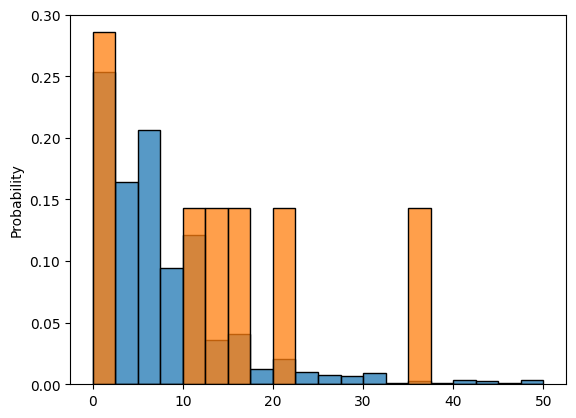

In [30]:
sns.histplot(df.filter(pl.col("sample_id") == "PD50523b")["both_mismatch"], stat="probability", bins=np.linspace(0,50,21))
sns.histplot(df.filter(pl.col("sample_id") == "PD50508f")["both_mismatch"], stat="probability", bins=np.linspace(0,50,21))

In [40]:
(complex_ann_snps_df
    .filter(pl.col("qual_start1") >= 60)
    .group_by("sample_id", "read_name", "read_length1")
    .agg(
        (pl.col("op1") == pl.col("op2")).sum().alias("n_both_mismatch"),
        ((pl.col("op1") == pl.col("op2")).sum() / pl.col("read_length1").first()).alias("n_both_mismatch_per_bp"),
    )
    .group_by("sample_id")
    .agg(
        mean_n_both_mismatches = pl.col("n_both_mismatch").mean(),
        mean_n_both_mismatches_per_bp = pl.col("n_both_mismatch_per_bp").mean(),
    )
    .sort("mean_n_both_mismatches_per_bp")
)

sample_id,mean_n_both_mismatches,mean_n_both_mismatches_per_bp
str,f64,f64
"""PD50477f""",5.925926,0.000434
"""PD50508f""",5.428571,0.000492
"""PD50523b""",6.243003,0.000503
"""PD50521b""",6.757576,0.000506
"""PD46180c""",6.883117,0.000528
"""PD50508b""",5.6,0.000586
"""PD50519d""",6.897959,0.000645
"""PD50489e""",6.309524,0.000846
"""PD50521e""",9.0,0.000923


### What is the baseline?

In [41]:
output_path = Path("/lustre/scratch122/tol/projects/sperm/results/Rahbari_20250212")

both_mismatches_stats_df = pl.concat([
    (
        pl.scan_parquet(glob.glob(str(
            output_path / f"read_analysis/{sample_set}/{sample_id}/{flow_cell}/*/annotated_0.95_high_confidence_snps.parquet"
        ))).with_columns(
            sample_id=pl.lit(sample_id), 
            flow_cell=pl.lit(flow_cell),
            flow_cell_type=pl.lit(flow_cell_type),        
        )
#        .filter(pl.col("qual_start1") >= 60)
        .group_by("sample_id", "read_name", "read_length1")
        .agg(
            (pl.col("op1") == pl.col("op2")).sum().alias("n_both_mismatch"),
            ((pl.col("op1") == pl.col("op2")).sum() / pl.col("read_length1").first()).alias("n_both_mismatch_per_bp"),
        )
        .group_by("sample_id")
        .agg(
            mean_n_both_mismatches = pl.col("n_both_mismatch").mean(),
            mean_n_both_mismatches_per_bp = pl.col("n_both_mismatch_per_bp").mean(),
        )
        .sort("mean_n_both_mismatches_per_bp")

        .collect(streaming=True)
    )
    for sample_set, sample_id, flow_cell, flow_cell_type, _ in tqdm.tqdm(rahbari_df.iter_rows())
#        if sample_id in ["PD50523b", "PD50477f"]
])


56it [02:48,  3.00s/it]


In [43]:
both_mismatches_stats_df

sample_id,mean_n_both_mismatches,mean_n_both_mismatches_per_bp
str,f64,f64
"""PD50521b""",0.596746,0.000044
"""PD50521b""",0.634562,0.000038
"""PD50521b""",0.77549,0.000047
"""PD50521b""",0.931537,0.000057
"""PD50521b""",0.777683,0.000047
"""PD50521e""",0.363869,0.000032
"""PD50521e""",0.394924,0.000035
"""PD50521e""",0.402596,0.000034
"""PD50521e""",0.33729,0.000031


In [56]:
output_path = Path("/lustre/scratch122/tol/projects/sperm/results/Rahbari_20250212")

both_mismatches_bq_stats_df = pl.concat([
    (
        pl.scan_parquet(glob.glob(str(
            output_path / f"read_analysis/{sample_set}/{sample_id}/{flow_cell}/*/annotated_0.95_high_confidence_snps.parquet"
        ))).with_columns(
            sample_id=pl.lit(sample_id), 
            flow_cell=pl.lit(flow_cell),
            flow_cell_type=pl.lit(flow_cell_type),        
        )
#        .filter(pl.col("qual_start1") >= 60)
        .with_columns(
            both_mismatches = (pl.col("op1") == pl.col("op2")),
        )
        .group_by("sample_id", "flow_cell", "both_mismatches", "qual_start1")
        .len()
        .collect(streaming=True)
    )
    for sample_set, sample_id, flow_cell, flow_cell_type, _ in tqdm.tqdm(rahbari_df.iter_rows())
#        if sample_id in ["PD50523b", "PD50477f"]
])

both_mismatches_bq_stats_df = (both_mismatches_bq_stats_df
    .group_by("sample_id", "both_mismatches", "qual_start1")
    .agg(pl.col("len").sum())
    .sort("sample_id", "both_mismatches", "qual_start1")
)

56it [01:10,  1.26s/it]


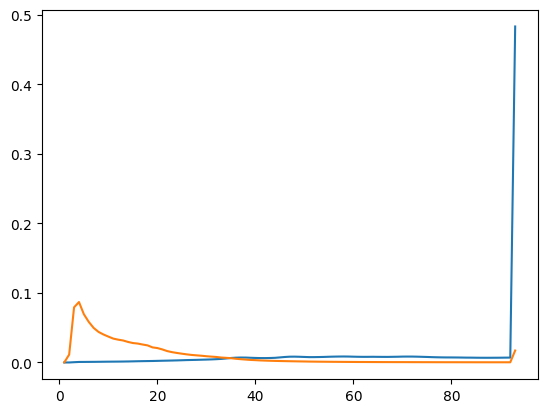

In [61]:
sid = "PD50523b"

df = both_mismatches_bq_stats_df.filter(pl.col("sample_id") == sid)
plt.plot(
    df.filter(~pl.col("both_mismatches"))["qual_start1"],
    df.filter(~pl.col("both_mismatches"))["len"] / df.filter(~pl.col("both_mismatches"))["len"].sum(),
    label = "SNP",
);
plt.plot(
    df.filter(pl.col("both_mismatches"))["qual_start1"],
    df.filter(pl.col("both_mismatches"))["len"]  / df.filter(pl.col("both_mismatches"))["len"].sum(),
    label = "Both",
);

### BQ distribution for mismatches in complex reads

In [64]:
complex_both_mismatches_bq_stats_df = (complex_ann_snps_df
    .with_columns(
        both_mismatches = (pl.col("op1") == pl.col("op2")),
    ) 
    .group_by("sample_id", "flow_cell", "both_mismatches", "qual_start1")
    .len()
)

complex_both_mismatches_bq_stats_df = (complex_both_mismatches_bq_stats_df
    .group_by("sample_id", "both_mismatches", "qual_start1")
    .agg(pl.col("len").sum())
    .sort("sample_id", "both_mismatches", "qual_start1")
)

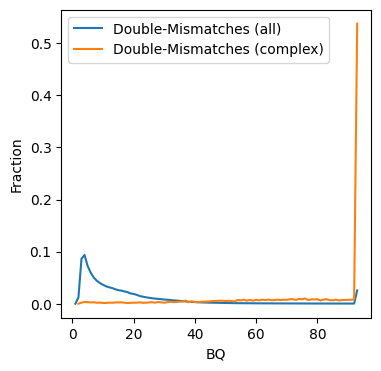

In [78]:
# sid = "PD50519d"
# df = both_mismatches_bq_stats_df.filter(pl.col("sample_id") == sid)
# cdf = complex_both_mismatches_bq_stats_df.filter(pl.col("sample_id") == sid)

#sid = "PD50519d"
df = both_mismatches_bq_stats_df.group_by("both_mismatches", "qual_start1").agg(pl.col("len").sum()).sort("qual_start1")
cdf = complex_both_mismatches_bq_stats_df.group_by("both_mismatches", "qual_start1").agg(pl.col("len").sum()).sort("qual_start1")

plt.figure(figsize=(4,4));
plt.plot(
    df.filter(pl.col("both_mismatches"))["qual_start1"],
    df.filter(pl.col("both_mismatches"))["len"]  / df.filter(pl.col("both_mismatches"))["len"].sum(),
    label = "Double-Mismatches (all)",
);

plt.plot(
    cdf.filter(pl.col("both_mismatches"))["qual_start1"],
    cdf.filter(pl.col("both_mismatches"))["len"]  / cdf.filter(pl.col("both_mismatches"))["len"].sum(),
    label = "Double-Mismatches (complex)",
);

plt.legend()
plt.xlabel("BQ");
plt.ylabel("Fraction");

# Paint

In [14]:
def paint_complex_events(
    df,
    figsize=(10,8),
):

    complex_rows = df.rows(named=True)

    fig, ax = plt.subplots(figsize=figsize)

    for i, row in enumerate(complex_rows):

        ax.plot(
            [0, row["read_length"]],
            [i,i],
            color="black",
            lw=0.5,
            alpha=0.5,
        )

        colors = [0]
        for j in range(1, len(row["snp_positions_on_read"])):
            if j in row["idx_transitions"]:
                colors.append(1-colors[-1])
            else:
                colors.append(colors[-1])

        ax.scatter(
            x = row["snp_positions_on_read"],
            y = [i] * len(row["snp_positions_on_read"]),
            s = 6,
            c = [["blue", "red"][x] for x in colors],
        )

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    ax.set_xlabel("Position in read (bp)");
    ax.set_yticks([], []); #np.arange(len(complex_rows)), np.arange(len(complex_rows)), fontsize=7);
    
    return ax

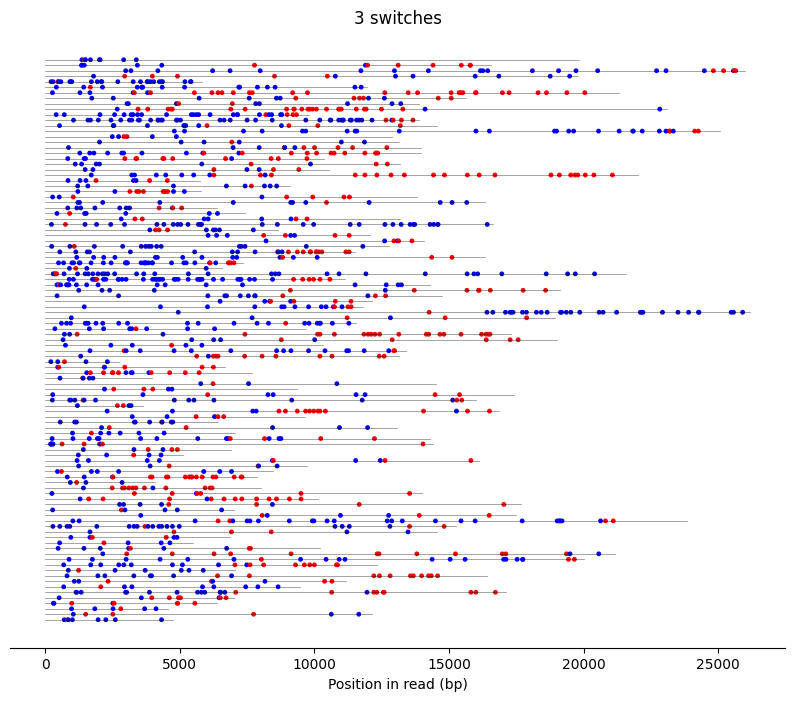

In [18]:
ax = paint_complex_events(
    (dense_reads_with_detection_df
        .filter(pl.col("idx_transitions").list.len() == 3)
    ),
    figsize=(10,8),
)

ax.set_title("3 switches");

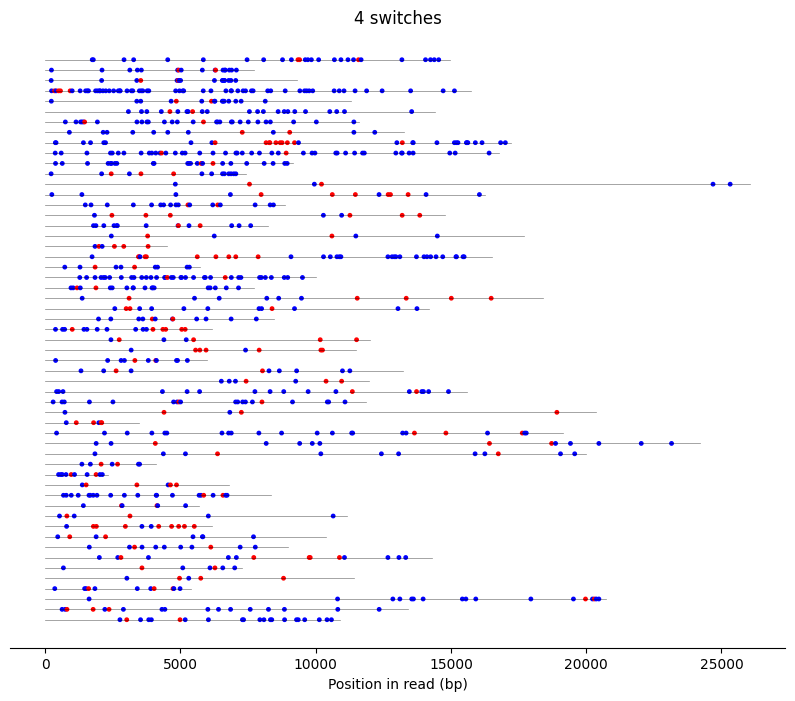

In [19]:
ax = paint_complex_events(
    (dense_reads_with_detection_df
        .filter(pl.col("idx_transitions").list.len() == 4)
    ),
    figsize=(10,8),
)

ax.set_title("4 switches");

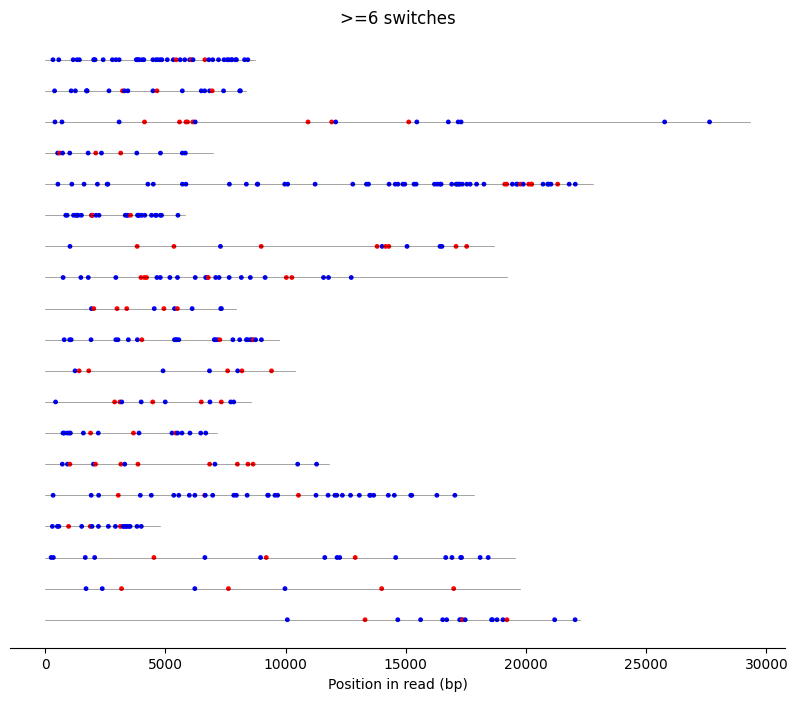

In [21]:
ax = paint_complex_events(
    (dense_reads_with_detection_df
        .filter(pl.col("idx_transitions").list.len() >= 6)
    ),
    figsize=(10,8),
)

ax.set_title(">=6 switches");

# Genetic length distribution

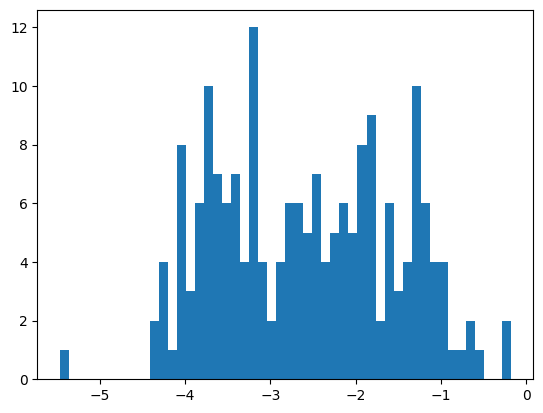

In [22]:
plt.hist(
    (dense_reads_with_detection_df["full_read_crossover_prob"]*1e2).log10(),
    bins=50,
);

In [24]:
(
    dense_reads_with_detection_df["full_read_crossover_prob"]*1e2 / 
    (dense_reads_with_detection_df["read_length"] / 1e6)
).mean()

2.409174018289901

# Does it have hostpots

In [8]:
dense_reads_with_detection_df.select(pl.col("AA_motif_center_pos").is_not_null()).mean()

AA_motif_center_pos
f64
0.212766


In [9]:
dense_reads_with_detection_df.select(pl.col("AA_motif_center_pos").is_not_null()).sum()

AA_motif_center_pos
u32
40


In [10]:
len(dense_reads_with_detection_df)

188

In [11]:
scipy.stats.binomtest(40, 188, 0.25)

BinomTestResult(k=40, n=188, alternative='two-sided', statistic=0.2127659574468085, pvalue=0.27337870580236745)

In [26]:
(dense_reads_with_detection_df
    .select(
        pl.col("idx_transitions").list.len().alias("n_trans"),
        pl.col("AA_motif_center_pos").is_not_null().alias("has_dsb"),
    )
    .group_by("n_trans")
    .agg(pl.col("has_dsb").mean())
    .sort("n_trans")
)

n_trans,has_dsb
u32,f64
3,0.281553
4,0.127273
5,0.181818
6,0.0
7,0.333333
8,0.0
9,1.0


# Compare numbers between individuals]

In [47]:
%%time
reads_df = pl.concat([
    pl.scan_parquet(
        f"/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/{focal_sample_id}/reads/{chrom}_RagTag.certainty_0.95.all_reads_structure_annotated.parquet"
    ) 
    for focal_sample_id in tqdm.tqdm(sample_ids)
    for chrom in aut_chrom_names
])

100%|██████████| 15/15 [00:00<00:00, 20.82it/s]

CPU times: user 194 ms, sys: 208 ms, total: 402 ms
Wall time: 757 ms


In [48]:
%%time
candidates_df = (reads_df
    .select(
        'read_name',
        'chrom',
        'sample_id',
        'is_high_quality_read',
        "high_quality_classification_class",
        "high_quality_classification_in_detectable_class",
    )
    .filter("is_high_quality_read")
    .filter(pl.col("high_quality_classification_class").is_not_null())
    .collect(streaming=True)
)

CPU times: user 34.4 s, sys: 6.22 s, total: 40.6 s
Wall time: 30.6 s


In [49]:
len(candidates_df)

9679

In [50]:
call_stats_df = (candidates_df    
    .pivot(
        values=["high_quality_classification_class"],
        index=["sample_id"],
        columns=["high_quality_classification_class"],
        aggregate_function='len'
    )
    .sort(by="sample_id")
    .select("sample_id", "CO", "GC", "ambiguous", "CNCO")
)

call_stats_df = (
    pl.DataFrame(
        {
            "sample_id": sample_presentation_order, 
            "paper_label_id": [sample_id_to_paper_label[x] for x in sample_presentation_order]
        }
    )
    .join(call_stats_df, on="sample_id")
)

with pl.Config(tbl_rows=40):
    display(call_stats_df.drop("sample_id"))

paper_label_id,CO,GC,ambiguous,CNCO
str,u32,u32,u32,u32
"""AA1-s1""",161,45,95,3
"""AA1-s2""",130,31,78,8
"""AA2-t1""",262,72,135,45
"""AA2-t2""",179,82,110,54
"""AA3""",205,73,126,31
"""AA4""",180,51,80,24
"""AA5""",520,233,419,13
"""AA6""",447,212,326,11
"""AA7""",501,212,346,18


In [59]:
call_stats_df.sum()

sample_id,paper_label_id,CO,GC,ambiguous,CNCO
str,str,u32,u32,u32,u32
null,null,4460,1759,3109,351


In [55]:
import scipy.stats

cont = np.array(
    [call_stats_df["CNCO"].to_numpy(), (call_stats_df["CO"]+call_stats_df["GC"]+call_stats_df["ambiguous"]).to_numpy()]
)

scipy.stats.chi2_contingency(cont)

Chi2ContingencyResult(statistic=389.5600391904709, pvalue=2.002452818846771e-74, dof=14, expected_freq=array([[  11.02427937,    8.95722699,   18.63973551,   15.41223267,
          15.77487344,   12.14846575,   42.97293109,   36.11902056,
          39.05641079,   35.21241864,   34.84977787,   19.83645005,
          15.37596859,   29.91786342,   15.70234528],
       [ 292.97572063,  238.04277301,  495.36026449,  409.58776733,
         419.22512656,  322.85153425, 1142.02706891,  959.88097944,
        1037.94358921,  935.78758136,  926.15022213,  527.16354995,
         408.62403141,  795.08213658,  417.29765472]]))

In [28]:
(dense_reads_with_detection_df
    .with_columns(pl.col("idx_transitions").list.len().alias("n_switches"))
    .filter(pl.col("n_switches") > 10)
    .sort("n_switches")
    .select("n_switches", "read_name", "chrom", "sample_id")
)


n_switches,read_name,chrom,sample_id
u32,str,str,str
11,"""m84047_240928_140551_s1/201983590/ccs""","""chr5""","""PD46180c"""
11,"""m84047_240928_151025_s3/219942845/ccs""","""chr1""","""PD50523b"""
11,"""m84047_240928_151025_s3/157485080/ccs""","""chr6""","""PD50523b"""
11,"""m84093_241009_101414_s1/194318210/ccs""","""chr8""","""PD50523b"""
11,"""m84047_240928_151025_s3/218236641/ccs""","""chr11""","""PD50523b"""
11,"""m84098_241009_114708_s4/158992428/ccs""","""chr14""","""PD50523b"""
11,"""m84047_240928_151025_s3/86509773/ccs""","""chr15""","""PD50523b"""
11,"""m84047_240927_134858_s1/249169861/ccs""","""chr11""","""PD50489e"""
12,"""m84047_240928_140551_s1/85725653/ccs""","""chr3""","""PD46180c"""
